## Classifier Performance: selecting for reobservation
#### Plot to show performance when selecting Lya QSOs for reobservation
In this notebook, we load the results from all of our classifiers on a DESI-like subset of the BOSS DR12Q Superset, and compare the results in the context of selecting high-z Lya QSOs for reobservation. We define different strategies for combining the classifiers' classifications, and assess which of these is preferable.

In [1]:
import copy
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from quasarnet.io import read_truth
from qn_analysis import plot, strategy, utils, variables

In [2]:
figsize = (12,8)
fontsize = 18

plt.rc('font', size=fontsize)

### Load the results from the different classifiers

In [3]:
## RR parameters
include_fits_rr = True

## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True

## SQ parameters
p_min = 0.32
include_p_sq = True

In [4]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [ ]:
data = {}

## Load the RRngp data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_sdr12q_coadd.fits'
data['RR'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RRngp data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_test_coadd_ngp.fits' 
data['RRngp'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RRngp random exp data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_sdr12q_randexp.fits'
data['RRngp randexp'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RRngp best exp data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_sdr12q_bestexp.fits'
data['RRngp bestexp'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)



## Load the RRarch data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_test_archetypes_coadd.fits'
data['RRarch'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RRarch randexp data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_test_archetypes_randexp.fits'
data['RRarch randexp'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)


## Load the RRngp data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_test_andmask_coadd.fits'
data['RR andmask'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RRngp data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_test_andmask_coadd_ngp.fits'
data['RRngp andmask'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RRngp random exp data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_test_andmask_randexp.fits'
data['RRngp andmask randexp'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)

## Load the RRngp random exp data.
f_rr = variables.OUTDIR+'/results/rr_results/rr_test_andmask_bestexp.fits'
data['RRngp andmask bestexp'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr)



## Load the QN data.
singexp_mode = 'randexp'
f_qn = variables.OUTDIR+'/outputs/qn_outputs/main_setup/{m}/prop_0.1/model_indtrain_0_0/qnAll-train_0.1_{m}_0_0-test_{m}.fits'.format(m=singexp_mode)
data['QNrandexp'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the QN data.
singexp_mode = 'bestexp'
f_qn = variables.OUTDIR+'/outputs/qn_outputs/main_setup/{m}/prop_0.1/model_indtrain_0_0/qnAll-train_0.1_{m}_0_0-test_{m}.fits'.format(m=singexp_mode)
data['QNbestexp'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the old QN data.
f_qn = '/global/homes/j/jfarr/Projects/QuasarNET/test_olddat/qnAll-train_0.1_randexp_olddat-test_randexp_olddat.fits'
data['QN andmask randexp'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)


### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [ ]:
data_table = utils.reduce_data_to_table(data,truth,
                                  include_c_qn=include_c_qn,
                                  include_p_sq=include_p_sq,
                                  include_fits_rr=include_fits_rr)
print(len(data_table))
data_table[:5]

In [ ]:
# Include only objects in the data table that have the highest confidence level, and VI redshift not equal to -1.
w = (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>-1)
data_table = data_table[w]
len(data_table)

### Evaluate performance of classifiers at selecting for reobservation.
xxx

In [64]:
data_table_archive = copy.deepcopy(data_table)

In [65]:
## Define parameters
n_highz_desi = 50
zcut = 2.1
dv_max = 6000. # km/s

# QN/SQ confidence thresholds.
cth_min = 0.0
cth_max = 1.0
n_int = 10
c_th_values = np.arange(cth_min,cth_max,(1/n_int)*(cth_max-cth_min))

In [71]:
# Define the strategies.
stratdefs = {}

# RR definitions.
strat = strategy.Strategy('rr')
preds = [strat.predict(data_table)]
stratdefs['RR'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                   'color': 'k', 'marker': 'd'}

# RRngp definitions.
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'RRngp'})
preds = [strat.predict(data_table)]
stratdefs['RRngp'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                      'color': 'r', 'marker': 'd'}

# RRngp randexp definitions.
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'RRngp randexp'})
preds = [strat.predict(data_table)]
stratdefs['RRngp randexp'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                      'color': 'green', 'marker': 'd'}

# RRngp bestexp definitions.
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'RRngp bestexp'})
preds = [strat.predict(data_table)]
stratdefs['RRngp bestexp'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                      'color': 'blue', 'marker': 'd'}

# RRarch definitions.
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'RRarch'})
preds = [strat.predict(data_table)]
stratdefs['RRarch'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                      'color': 'k', 'marker': 'P'}

# RRarch randexp definitions.
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'RRarch randexp'})
preds = [strat.predict(data_table)]
stratdefs['RRarch randexp'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                      'color': 'green', 'marker': 'P'}


# RR andmask definitions.
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'RR andmask'})
preds = [strat.predict(data_table)]
stratdefs['RR andmask'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                      'color': 'k', 'marker': 'p'}

# RRngp andmask definitions.
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'RRngp andmask'})
preds = [strat.predict(data_table)]
stratdefs['RRngp andmask'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                      'color': 'r', 'marker': 'p'}

# RRngp andmask randexp definitions.
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'RRngp andmask randexp'})
preds = [strat.predict(data_table)]
stratdefs['RRngp andmask randexp'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                              'color': 'green', 'marker': 'p'}

# RRngp andmask bestexp definitions.
strat = strategy.Strategy('rr',cf_kwargs={'rr_name':'RRngp andmask bestexp'})
preds = [strat.predict(data_table)]
stratdefs['RRngp andmask bestexp'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                              'color': 'blue', 'marker': 'p'}

# QN randexp definitions.
n_detect = 1
strat = strategy.Strategy('qn',cf_kwargs={'qn_name':'QNrandexp'})
preds = [strat.predict(data_table,c_kwargs={'c_th':c_th,'n_detect':n_detect}) for c_th in c_th_values]
stratdefs['QN randexp c_th'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                   'color': c_th_values, 'marker': 'o'}

# QN 1 point randexp definitions.
c_th = 0.3
n_detect = 1
strat = strategy.Strategy('qn',cf_kwargs={'qn_name':'QNrandexp'})
preds = [strat.predict(data_table,c_kwargs={'c_th':c_th,'n_detect':n_detect})]
stratdefs['QN randexp'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                   'color': 'green', 'marker': 'o'}

# QN 1 point bestexp definitions.
c_th = 0.3
n_detect = 1
strat = strategy.Strategy('qn',cf_kwargs={'qn_name':'QNbestexp'})
preds = [strat.predict(data_table,c_kwargs={'c_th':c_th,'n_detect':n_detect})]
stratdefs['QN bestexp'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                   'color': 'blue', 'marker': 'o'}

# QN 1 point andmask randexp definitions.
c_th = 0.3
n_detect = 1
strat = strategy.Strategy('qn',cf_kwargs={'qn_name':'QN andmask randexp'})
preds = [strat.predict(data_table,c_kwargs={'c_th':c_th,'n_detect':n_detect})]
stratdefs['QN andmask randexp'] = {'w': [pred.get_ishighzqso(zcut=zcut) for pred in preds],
                   'color': 'green', 'marker': 's'}

## QN|RR 1 point definitions.
n_detect = 1
stratdefs['QN|RRngp randexp'] = {'w': [w|stratdefs['RRngp randexp']['w'][0] for w in stratdefs['QN randexp']['w']],
                      'color': 'green', 'marker': 'x'}

## QN|RR 1 point definitions.
n_detect = 1
stratdefs['QN|RRngp bestexp'] = {'w': [w|stratdefs['RRngp bestexp']['w'][0] for w in stratdefs['QN bestexp']['w']],
                      'color': 'blue', 'marker': 'x'}

## QN|RR 1 point definitions.
n_detect = 1
stratdefs['QN|RRngp andmask randexp'] = {'w': [w|stratdefs['RRngp andmask randexp']['w'][0] for w in stratdefs['QN randexp']['w']],
                      'color': 'green', 'marker': '+'}

## QN|RR 1 point definitions.
n_detect = 1
stratdefs['QN|RRngp andmask bestexp'] = {'w': [w|stratdefs['RRngp andmask bestexp']['w'][0] for w in stratdefs['QN bestexp']['w']],
                      'color': 'blue', 'marker': '+'}


In [72]:
marker_step = {0:'o',1:'d',2:'^',3:'v',4:'*',5:'x',6:'s',7:'X',}
exptype = 'randexp'

dc_th_values = [2.,5.,10.,20.]
n_th_values = [2,3]
drc_th_values = [0.,0.0001,0.0005,0.001,0.002]

for i,delta_chi2_th in enumerate(dc_th_values):

    # RRngp nonbest definitions.
    c = 'RRngp {}'.format(exptype)
    delta_chi2 = data_table['FIT_CHI2_{}'.format(c)].data - data_table['FIT_CHI2_{}'.format(c)].data[:,0].reshape((len(data_table),1))
    below_th = delta_chi2<=delta_chi2_th
    ishighzqso = ((data_table['FIT_SPECTYPE_{}'.format(c)].data=='QSO') & (data_table['FIT_Z_{}'.format(c)].data>=2.1) & below_th).any(axis=1)
    stratdefs['RRngp-{}-dc2th {}'.format(exptype[0],delta_chi2_th)] = {'w': [ishighzqso],
                                  'color': 'red', 'marker': marker_step[i]}
    
    ## QN|RR 1 point definitions.
    n_detect = 1
    stratdefs['QN|RRngp-{}-dc2th {}'.format(exptype[0],delta_chi2_th)] = {'w': [w|stratdefs['RRngp-{}-dc2th {}'.format(exptype[0],delta_chi2_th)]['w'][0] for w in stratdefs['QN {}'.format(exptype)]['w']],
                      'color': 'orange', 'marker': marker_step[i]}

    # RRngp andmask nonbest definitions.
    c = 'RRngp andmask {}'.format(exptype)
    delta_chi2 = data_table['FIT_CHI2_{}'.format(c)].data - data_table['FIT_CHI2_{}'.format(c)].data[:,0].reshape((len(data_table),1))
    below_th = delta_chi2<=delta_chi2_th
    ishighzqso = ((data_table['FIT_SPECTYPE_{}'.format(c)].data=='QSO') & (data_table['FIT_Z_{}'.format(c)].data>=2.1) & below_th).any(axis=1)
    stratdefs['RRngp-a-{}-dc2th {}'.format(exptype[0],delta_chi2_th)] = {'w': [ishighzqso],
                                  'color': 'red', 'marker': marker_step[i]}
    
    ## QN|RR 1 point definitions.
    n_detect = 1
    stratdefs['QN|RRngp-a-{}-dc2th {}'.format(exptype[0],delta_chi2_th)] = {'w': [w|stratdefs['RRngp-a-{}-dc2th {}'.format(exptype[0],delta_chi2_th)]['w'][0] for w in stratdefs['QN {}'.format(exptype)]['w']],
                      'color': 'orange', 'marker': marker_step[i]}

for i,n_th in enumerate(n_th_values):

    # RRngp nonbest definitions.
    c = 'RRngp {}'.format(exptype)
    inds = np.array([list(range(9)) for i in range(len(data_table))])
    below_th = inds<=n_th
    ishighzqso = ((data_table['FIT_SPECTYPE_{}'.format(c)].data=='QSO') & (data_table['FIT_Z_{}'.format(c)].data>=2.1) & below_th).any(axis=1)
    stratdefs['RRngp-{}-nfth {}'.format(exptype[0],n_th)] = {'w': [ishighzqso],
                                  'color': 'grey', 'marker': marker_step[i]}

    ## QN|RR 1 point definitions.
    n_detect = 1
    stratdefs['QN|RRngp-{}-nfth {}'.format(exptype[0],n_th)] = {'w': [w|stratdefs['RRngp-{}-nfth {}'.format(exptype[0],n_th)]['w'][0] for w in stratdefs['QN {}'.format(exptype)]['w']],
                      'color': 'k', 'marker': marker_step[i]}

    # RRngp nonbest definitions.
    c = 'RRngp andmask {}'.format(exptype)
    inds = np.array([list(range(9)) for i in range(len(data_table))])
    below_th = inds<=n_th
    ishighzqso = ((data_table['FIT_SPECTYPE_{}'.format(c)].data=='QSO') & (data_table['FIT_Z_{}'.format(c)].data>=2.1) & below_th).any(axis=1)
    stratdefs['RRngp-a-{}-nfth {}'.format(exptype[0],n_th)] = {'w': [ishighzqso],
                                  'color': 'grey', 'marker': marker_step[i]}

    ## QN|RR 1 point definitions.
    n_detect = 1
    stratdefs['QN|RRngp-a-{}-nfth {}'.format(exptype[0],n_th)] = {'w': [w|stratdefs['RRngp-a-{}-nfth {}'.format(exptype[0],n_th)]['w'][0] for w in stratdefs['QN {}'.format(exptype)]['w']],
                      'color': 'k', 'marker': marker_step[i]}


for i,delta_rchi2_th in enumerate(drc_th_values):

    # RRngp nonbest definitions.
    c = 'RRngp {}'.format(exptype)
    delta_rchi2 = data_table['FIT_RCHI2_{}'.format(c)].data - data_table['FIT_RCHI2_{}'.format(c)].data[:,0].reshape((len(data_table),1))
    below_th = delta_rchi2<=delta_rchi2_th
    ishighzqso = ((data_table['FIT_SPECTYPE_{}'.format(c)].data=='QSO') & (data_table['FIT_Z_{}'.format(c)].data>=2.1) & below_th).any(axis=1)
    stratdefs['RRngp-{}-drc2th {}'.format(exptype[0],delta_rchi2_th)] = {'w': [ishighzqso],
                                  'color': 'magenta', 'marker': marker_step[i]}
    
    ## QN|RR 1 point definitions.
    n_detect = 1
    stratdefs['QN|RRngp-{}-drc2th {}'.format(exptype[0],delta_rchi2_th)] = {'w': [w|stratdefs['RRngp-{}-drc2th {}'.format(exptype[0],delta_rchi2_th)]['w'][0] for w in stratdefs['QN {}'.format(exptype)]['w']],
                      'color': 'purple', 'marker': marker_step[i]}

    # RRngp andmask nonbest definitions.
    c = 'RRngp andmask {}'.format(exptype)
    delta_rchi2 = data_table['FIT_RCHI2_{}'.format(c)].data - data_table['FIT_RCHI2_{}'.format(c)].data[:,0].reshape((len(data_table),1))
    below_th = delta_rchi2<=delta_rchi2_th
    ishighzqso = ((data_table['FIT_SPECTYPE_{}'.format(c)].data=='QSO') & (data_table['FIT_Z_{}'.format(c)].data>=2.1) & below_th).any(axis=1)
    stratdefs['RRngp-a-{}-drc2th {}'.format(exptype[0],delta_rchi2_th)] = {'w': [ishighzqso],
                                  'color': 'magenta', 'marker': marker_step[i]}
    
    ## QN|RR 1 point definitions.
    n_detect = 1
    stratdefs['QN|RRngp-a-{}-drc2th {}'.format(exptype[0],delta_rchi2_th)] = {'w': [w|stratdefs['RRngp-a-{}-drc2th {}'.format(exptype[0],delta_rchi2_th)]['w'][0] for w in stratdefs['QN {}'.format(exptype)]['w']],
                      'color': 'purple', 'marker': marker_step[i]}



In [73]:
## QN|RR 1 point definitions.
for i,delta_rchi2_th in enumerate(drc_th_values):
    n_detect = 1
    stratdefs['QN|RRngp-a-{}-drc2th {} c_th'.format(exptype[0],delta_rchi2_th)] = {'w': [w|stratdefs['RRngp-a-{}-drc2th {}'.format(exptype[0],delta_rchi2_th)]['w'][0] for w in stratdefs['QN {} c_th'.format(exptype)]['w']],
                      'color': c_th_values, 'marker': marker_step[i]}

In [74]:
# Check that we haven't accidentally overwritten any data.
assert (data_table==data_table_archive).all()

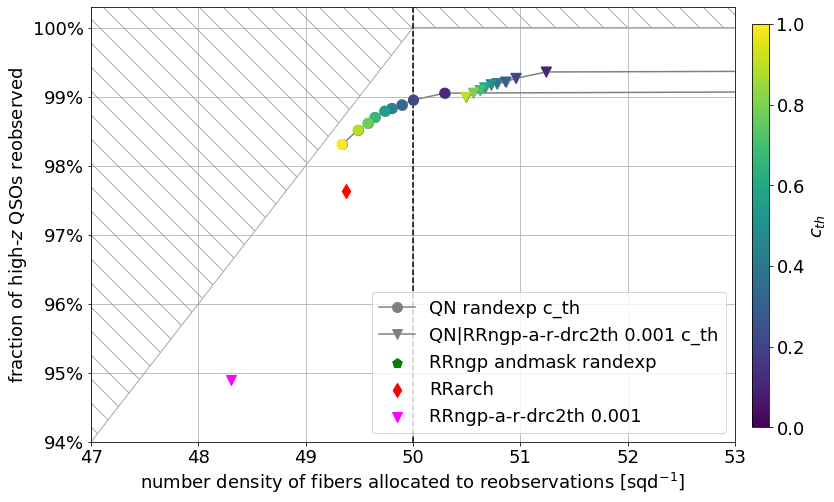

In [75]:
## Standard version of plot
drc2_th = 0.001
plot_strategies = ['RRngp andmask {}'.format(exptype),'RRarch']
plot_strategies += ['QN {} c_th'.format(exptype)]

plot_strategies += ['RRngp-a-{}-drc2th {}'.format(exptype[0],drc2_th)]
plot_strategies += ['QN|RRngp-a-{}-drc2th {} c_th'.format(exptype[0],drc2_th)] 
        
filename = '../plots/classifier_performance_selecting_for_reobservation_testnonbest_{}_rchi2.pdf'.format(exptype)
xmin,xmax = (47,53)
ymin = 0.94

# Define the strategies.
strategies = {s: stratdefs[s] for s in plot_strategies}

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=(12,8),nydec=0,point_shift=0.00)
plt.show()

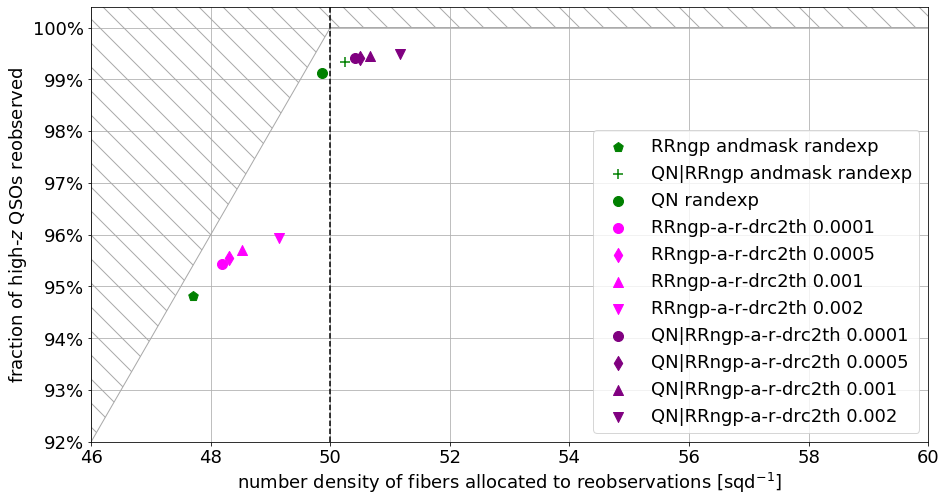

In [33]:
## Standard version of plot
plot_strategies = ['RRngp andmask {}'.format(exptype), 'QN|RRngp andmask {}'.format(exptype)]
plot_strategies += ['QN {}'.format(exptype)]

plot_strategies += ['RRngp-a-{}-drc2th {}'.format(exptype[0],delta_rchi2_th) for delta_rchi2_th in drc_th_values]
plot_strategies += ['QN|RRngp-a-{}-drc2th {}'.format(exptype[0],delta_rchi2_th) for delta_rchi2_th in drc_th_values] 
        
filename = '../plots/classifier_performance_selecting_for_reobservation_testnonbest_{}_rchi2.pdf'.format(exptype)
xmin,xmax = (46,60)
ymin = 0.92

# Define the strategies.
strategies = {s: stratdefs[s] for s in plot_strategies}

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=(15,8),nydec=0,point_shift=0.00)
plt.show()

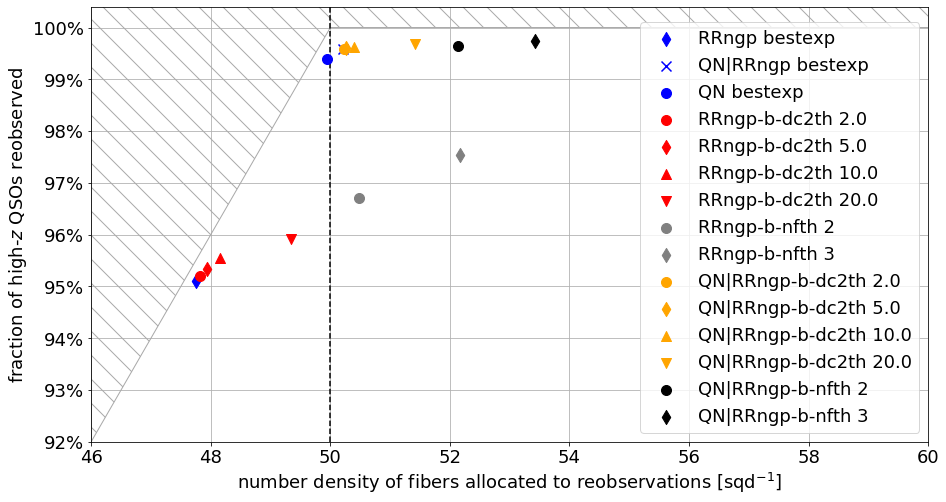

In [19]:
## Standard version of plot
plot_strategies = ['RRngp {}'.format(exptype), 'QN|RRngp {}'.format(exptype)]
plot_strategies += ['QN {}'.format(exptype)]

plot_strategies += ['RRngp-{}-dc2th {}'.format(exptype[0],delta_chi2_th) for delta_chi2_th in dc_th_values]
plot_strategies += ['RRngp-{}-nfth {}'.format(exptype[0],n_th) for n_th in n_th_values]
plot_strategies += ['QN|RRngp-{}-dc2th {}'.format(exptype[0],delta_chi2_th) for delta_chi2_th in dc_th_values] 
plot_strategies += ['QN|RRngp-{}-nfth {}'.format(exptype[0],n_th) for n_th in n_th_values] 
        
filename = '../plots/classifier_performance_selecting_for_reobservation_testnonbest_{}.pdf'.format(exptype)
xmin,xmax = (46,60)
ymin = 0.92

# Define the strategies.
strategies = {s: stratdefs[s] for s in plot_strategies}

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=(15,8),nydec=0,point_shift=0.00)
plt.show()

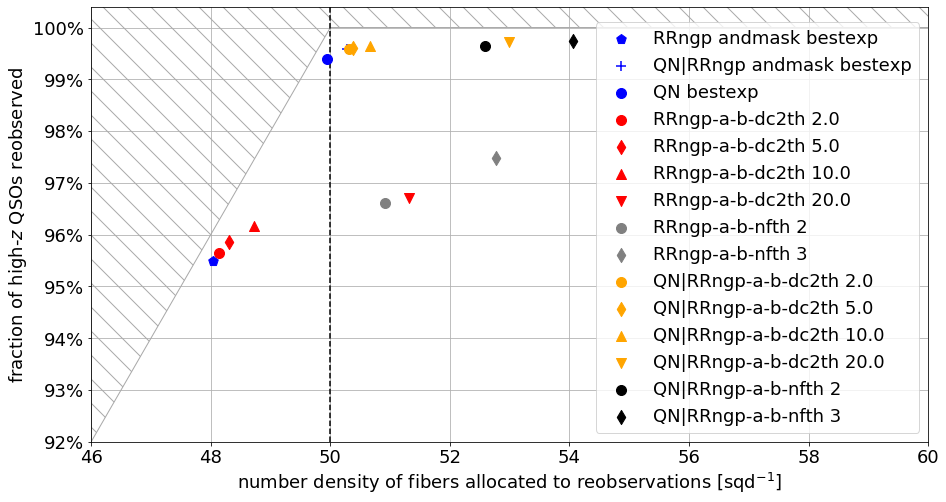

In [47]:
## Standard version of plot
plot_strategies = ['RRngp andmask {}'.format(exptype), 'QN|RRngp andmask {}'.format(exptype)]
plot_strategies += ['QN {}'.format(exptype)]
if exptype=='randexp':
    plot_strategies += ['QN andmask {}'.format(exptype)]

plot_strategies += ['RRngp-a-{}-dc2th {}'.format(exptype[0],delta_chi2_th) for delta_chi2_th in dc_th_values]
plot_strategies += ['RRngp-a-{}-nfth {}'.format(exptype[0],n_th) for n_th in n_th_values]
plot_strategies += ['QN|RRngp-a-{}-dc2th {}'.format(exptype[0],delta_chi2_th) for delta_chi2_th in dc_th_values] 
plot_strategies += ['QN|RRngp-a-{}-nfth {}'.format(exptype[0],n_th) for n_th in n_th_values] 
        
filename = '../plots/classifier_performance_selecting_for_reobservation_testnonbest_andmask_{}.pdf'.format(exptype)
xmin,xmax = (46,60)
ymin = 0.92

# Define the strategies.
strategies = {s: stratdefs[s] for s in plot_strategies}

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=(15,8),nydec=0,point_shift=0.00)
plt.show()

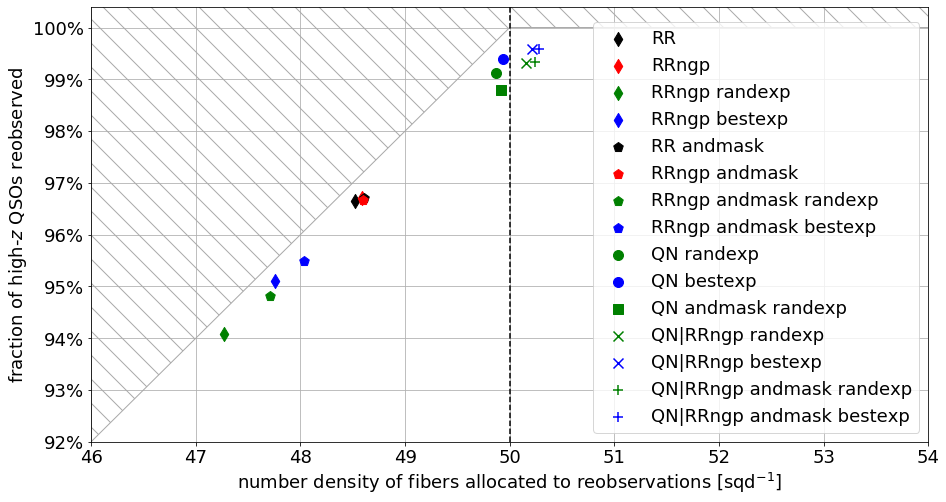

In [34]:
## Standard version of plot
plot_strategies = ['RR','RRngp','RRngp randexp','RRngp bestexp',
                   'RR andmask','RRngp andmask','RRngp andmask randexp','RRngp andmask bestexp',
                   'QN randexp','QN bestexp','QN andmask randexp',
                   'QN|RRngp randexp','QN|RRngp bestexp','QN|RRngp andmask randexp','QN|RRngp andmask bestexp'
                   'RRarch', 'RRarch randexp']

#plot_strategies = ['RR','RRngp randexp','RRngp bestexp',
#                   'RR andmask','RRngp andmask','RRngp andmask randexp','RRngp andmask bestexp',
#                   'QN randexp','QN bestexp','QN andmask randexp',
#                   'QN|RRngp randexp','QN|RRngp bestexp','QN|RRngp andmask randexp','QN|RRngp andmask bestexp']



filename = '../plots/classifier_performance_selecting_for_reobservation_testrrandmask.pdf'
xmin,xmax = (46,54)
ymin = 0.92

# Define the strategies.
strategies = {s: stratdefs[s] for s in plot_strategies}

# Make the plot.
fig, axs = plot.plot_reobservation_performance(data_table,strategies,filename=filename,
                                    dv_max=dv_max,zcut=zcut,ymin=ymin,xmin=xmin,xmax=xmax,
                                    verbose=False,n_highz_desi=n_highz_desi,
                                    figsize=(15,8),nydec=0,point_shift=0.00)
plt.show()